In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
import tensorflow.keras as keras

plt.style.use('dark_background')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = sns.color_palette('dark'))
plt.rcParams['figure.figsize'] = (20 , 20)

In [13]:
# !gdown 151WbWURL8IPXqhxi8vLCx7pmtvchegpZ --output ../data/
# !unzip ../data/PistolData_merged.zip -d ../data/
# !rm -R ../data/PistolData_merged.zip

In [17]:
import os
import cv2
datapath = '../../data/vision/PistolData_merged/'

annotfiles = sorted(os.listdir(f"{datapath}pistol_annotations"))
imagefiles = sorted(os.listdir(f"{datapath}pistol_images"))
imagefiles[:5]

['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '1001.jpg']

In [18]:
img_h = 416
img_w = 416
def get_box(annotation):
    x , y , w , h = annotation[1] , annotation[2] , annotation[3] , annotation[4]
    x1 , y1 = int((x - w/2) * img_w) , int((y - h / 2) * img_h)
    x2 , y2 = int((x + w/2) * img_w) , int((y + h / 2) * img_h)

    return x1 , y1 , x2 , y2

def plot_image(image , annotation):
    box = get_box(annotation)
    image = cv2.rectangle(image , (box[0] , box[1]) , (box[2] , box[3]) , (255,255,0), 3)
    plt.imshow(image)
    plt.axis('off')

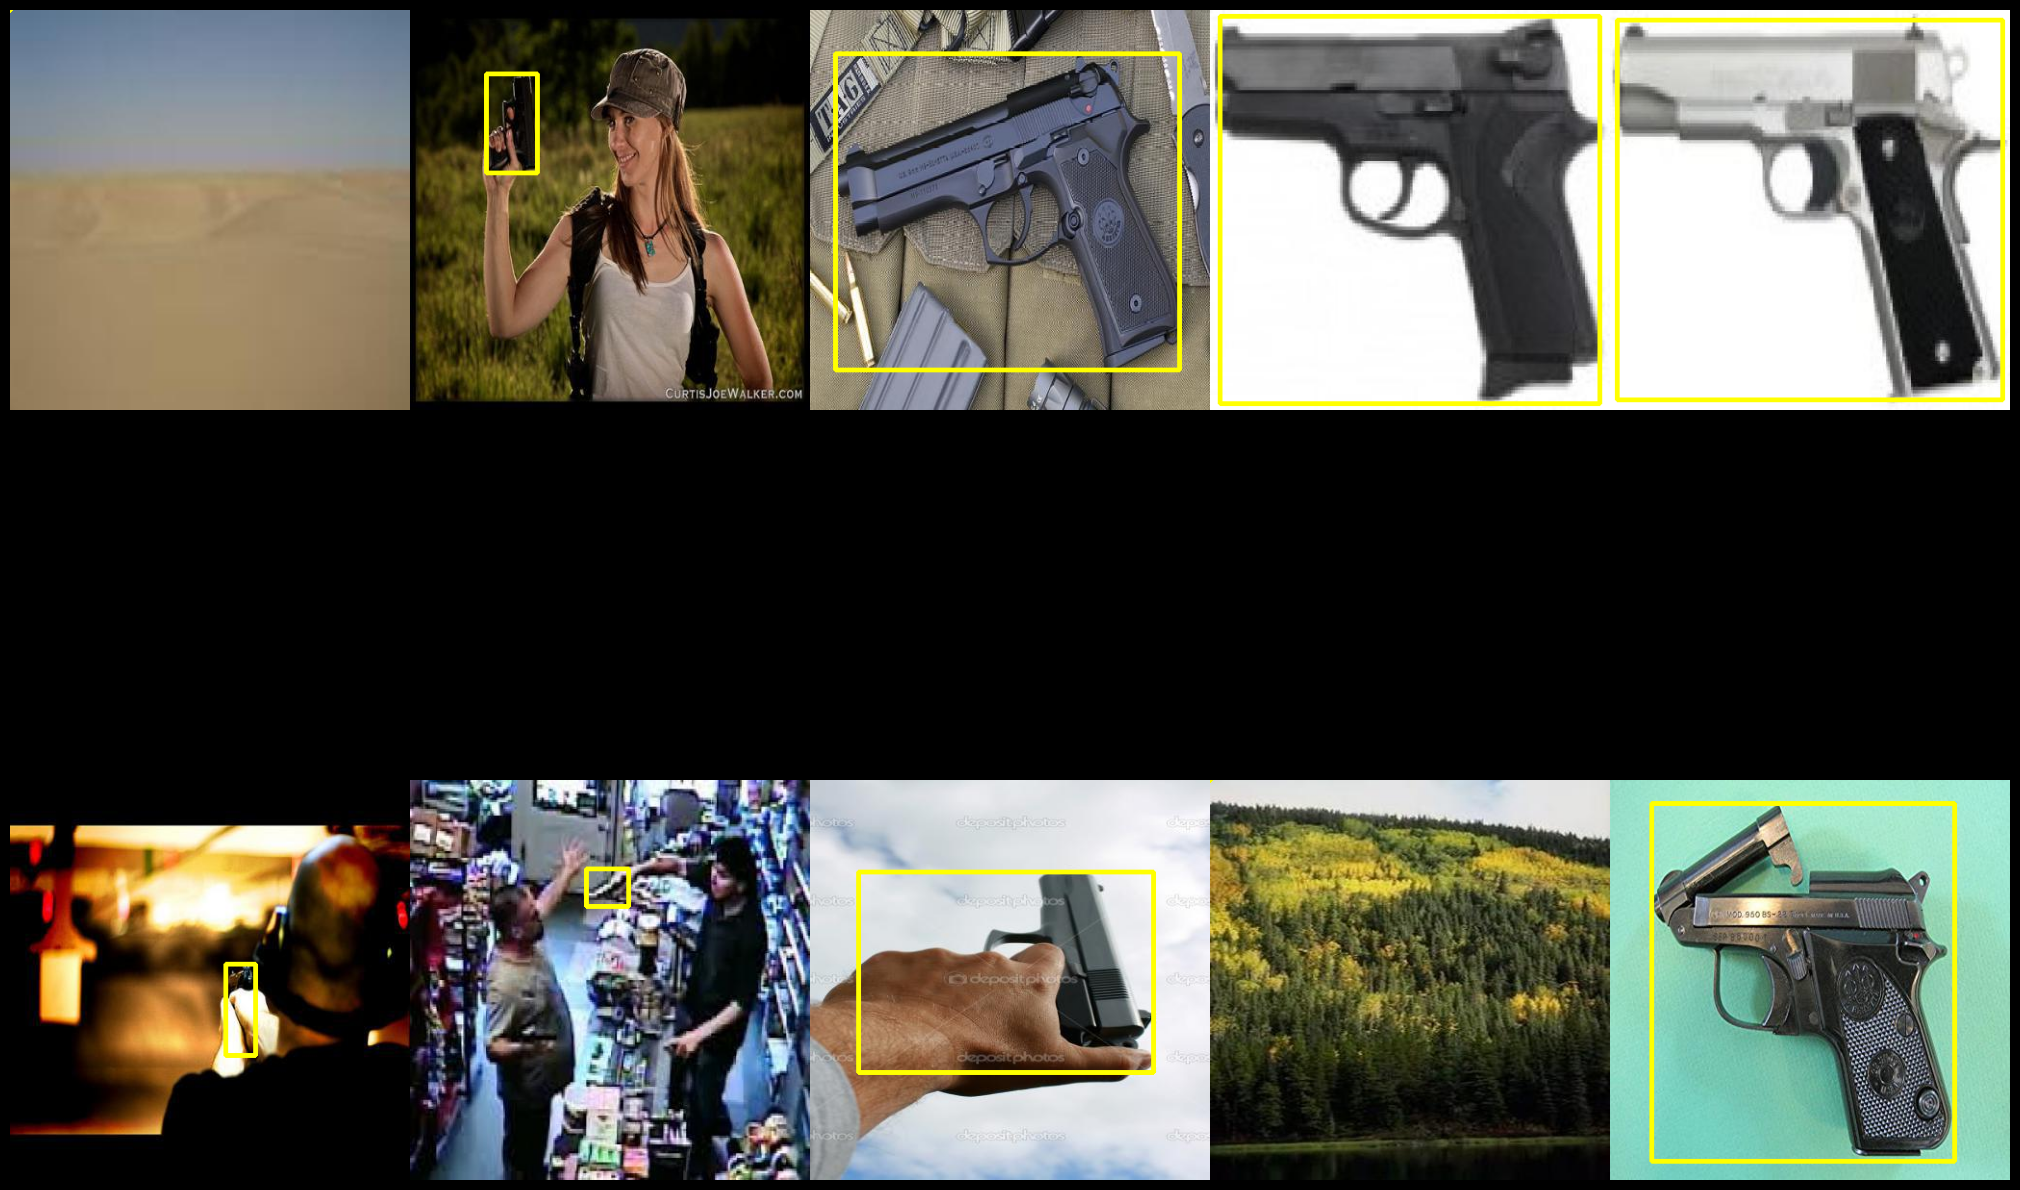

In [19]:
#plot sample images:


indices = np.random.randint(0 , len(imagefiles) , 10)

# plt.figure(figsize=(10 , 10))
for i , index in enumerate(indices):
    plt.subplot(2 , 5, i + 1)
    image = plt.imread(f"{datapath}pistol_images/{imagefiles[index]}")
    image = image.copy()
    annotationpath = f"{datapath}pistol_annotations/{annotfiles[index]}"
    # print(annotationpath , index , imagefiles[index])
    with open(annotationpath , 'r') as f:
        bbox = (f.readlines())
        annotation = [float(element) for element in bbox[0].split(' ')]
    plot_image(image , annotation)

plt.subplots_adjust(wspace= 0 , hspace = 0)
plt.tight_layout(pad = 0)

## load the dataset into arrays:

- array of images , classes and bounding boxes:


In [46]:
# fn to get annotations and class separately from each annotation file:
def segannot(file):
    with open(f'{datapath}pistol_annotations/{file}' , 'r') as f:
        content = f.readline()
    content = [float(el) for el in content.split()]
    return (content[0] , content[1:])

def getdata(imagefile , annotfile):
    image = plt.imread(f"{datapath}pistol_images/{imagefile}")
    cl , annotations = segannot(annotfile)
    return (True , image , cl , annotations)


images , classes , boxes = [] , [] , []
for file in annotfiles:
    imagefile = f"{file[:-4]}.jpg"
    afile = file
    status , image , clabel , bbox = getdata(imagefile , file)
    if status == True and image.shape == (416 , 416 , 3):
        images.append(image)
        classes.append(clabel)
        boxes.append(bbox)
images , classes , boxes = np.array(images) , np.array(classes) , np.array(boxes)
images.shape , classes.shape , boxes.shape

((3703, 416, 416, 3), (3703,), (3703, 4))

In [48]:
# distribution of classes:
np.unique(classes , return_counts = True)

(array([0., 1.]), array([ 999, 2704]))

In [49]:
# divide model into train test split:
from sklearn.model_selection import train_test_split
ximage , xtimage , yclass , ytclass , ybox , ytbox = train_test_split(images , classes , boxes , test_size = 0.3 , random_state = 42) 
ximage.shape , xtimage.shape , yclass.shape , ytclass.shape , ybox.shape , ytbox.shape

((2592, 416, 416, 3),
 (1111, 416, 416, 3),
 (2592,),
 (1111,),
 (2592, 4),
 (1111, 4))

In [51]:
# create localization model using resnet101:
import tensorflow as tf
from tensorflow.keras.layers import Dense , Flatten , Input

r101 = tf.keras.applications.ResNet101(weights = 'imagenet' , include_top= False , input_tensor = Input(shape = (416 , 416 , 3)))
r101.trainable = False
rout = r101.output
flat = Flatten()(rout)

#classification head:
x = Dense(128 , activation = 'relu')(flat)
x = Dense(64 , activation = 'relu')(x)
x = Dense(32 , activation = 'relu')(x)
cout = Dense(1 , activation = 'sigmoid' , name = 'class_output')(x)

#regression head:
x = Dense(128 , activation = 'relu')(flat)
x = Dense(64 , activation = 'relu')(x)
x = Dense(32 , activation = 'relu')(x)
rout = Dense(4 , activation = 'sigmoid' , name = 'box_output')(x)

model = tf.keras.models.Model(inputs = r101.input , outputs = [rout , cout])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 416, 416,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 422, 422,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 208, 208,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 208, 208,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 208, 208,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 210, 210,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 104, 104,  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 104, 104,  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 104, 104,  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 104, 104,  │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 104, 104,  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 104, 104,  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 104, 104,  │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 104, 104,  │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 104, 104,  │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 104, 104,  │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 104, 104,  │      1,024 │ conv2_block1_3_c

 Total params: 131,283,941 (500.81 MB)

 Trainable params: 88,625,765 (338.08 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

In [53]:
losses = {
    'class_output' : 'binary_crossentropy',
    'box_output': 'mean_squared_error'
}

loss_weights = {
    'box_output' : 4.0,
    'class_output' : 1.0
}

metrics = {
    'box_output' : 'mse',
    'class_output' : 'accuracy'
}

opt = tf.keras.optimizers.Adam(learning_rate = 1e-4)
model.compile(optimizer = opt , loss = losses , loss_weights = loss_weights , metrics = metrics)

In [54]:
logdir = './models/localization'
!rm -rf logdir
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# start training the model
history = model.fit(x= ximage , y={"class_output":yclass, "box_output":ybox},
                              validation_data=( xtimage , {"class_output":ytclass, "box_output":ytbox}),
                              batch_size=32,
                              epochs=10,
                              callbacks=(tensorboard_callback)
                           )

Epoch 1/10


2026-01-03 11:35:44.214223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


81/81 ━━━━━━━━━━━━━━━━━━━━ 60s 628ms/step - box_output_loss: 0.1855 - box_output_mse: 0.1855 - class_output_accuracy: 0.9723 - class_output_loss: 0.2364 - loss: 0.9783 - val_box_output_loss: 0.1286 - val_box_output_mse: 0.1285 - val_class_output_accuracy: 0.9982 - val_class_output_loss: 0.0443 - val_loss: 0.5588
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 46s 564ms/step - box_output_loss: 0.1264 - box_output_mse: 0.1264 - class_output_accuracy: 0.9998 - class_output_loss: 0.0023 - loss: 0.5078 - val_box_output_loss: 0.1287 - val_box_output_mse: 0.1286 - val_class_output_accuracy: 0.9955 - val_class_output_loss: 0.0419 - val_loss: 0.5564
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 47s 578ms/step - box_output_loss: 0.1266 - box_output_mse: 0.1266 - class_output_accuracy: 0.9968 - class_output_loss: 0.0294 - loss: 0.5358 - val_box_output_loss: 0.1306 - val_box_output_mse: 0.1305 - val_class_output_accuracy: 0.9973 - val_class_output_loss: 0.0353 - val_loss: 0.5577
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━

In [56]:
model.save('./models/localization/resnet_modified.keras')